In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Theory

We have to initialize the Hernquist model at equilibrium.

## 1) Positions

For the sampling of $r$, $\phi$ and $\theta$, we can apply the direct Monte Carlo sampling method.\
$\phi$ and $\theta$ are distributed uniformly on the surface of a sphere, so we sample $P \in [0,1]$ and then substitute it in:

$$p(\phi) = \dfrac{1}{2\pi} \:\: \Longrightarrow \:\: P(\phi) \, = \, \int^{\phi}_{0} p(\phi')d\phi' \, = \, \int^{\phi}_{0} \dfrac{1}{2\pi}d\phi' \, = \, \dfrac{\phi}{2\pi} \:\: \Longrightarrow \:\: {\color{lime} \large \phi(P) = 2\pi P} \:\:.$$

$$p(\theta) = \dfrac{\sin{\theta}}{2} \:\: \Longrightarrow \:\: P(\theta) \, = \, \int^{\theta}_{0} p(\theta')d\theta' \, = \, \int^{\theta}_{0} \dfrac{\sin{\theta'}}{2}d\theta' \, = \, \dfrac{1-\cos{\theta}}{2} \:\: \Longrightarrow \:\: {\color{lime} \large \theta(P) = \arccos(1-2P)} \:\:.$$

The sampling of the radial positions according to the Hernquist model is more tricky.

- We know that:
  $$\rho(r) \, = \, \dfrac{M_\text{tot}}{2\pi} \dfrac{a}{r \left(r+a\right)^3} \:\: , \:\: M(r) \, = \, \left(\dfrac{r}{r+a}\right)^2 M_{tot} \:\:.$$ 
  where $a$ is a scale factor.
</br></br>

- Therefore, the radial *pdf* $p(r)$ is given by:
  $$p(r) \, = \, \dfrac{4\pi r^2 \rho(r)}{M_{tot}} \, = \, \dfrac{2ar}{\left(r+a\right)^3} \:\:.$$
</br></br>

- We can integrate it over $r$ to obtain the *cdf* $P(r)$:
  $$P(r) \, = \, \int^{r}_{0} p(r')dr' \, = \, \left(\dfrac{r}{r+a}\right)^2 \, = \, \dfrac{M(r)}{M_{tot}} \in [0,1] \:\:.$$
</br></br>

- This relation can be easily inverted:
  $$P^{-1/2} \, = \, 1 + \dfrac{a}{r} \:\: \Longrightarrow \:\: \color{lime} \large r(P) \, = \, \dfrac{a}{P^{-1/2}-1} \, = \, \dfrac{\sqrt{P}}{1-\sqrt{P}}a \:\:.$$

## 2) Velocities

The orientations can be sampled just like $\phi$ and $\theta$, but the magnitudes require more work.

The distribution of the velocity magnitudes is given by:
$$p(v|r) \, \propto \, f\left(E(r,v)\right) v^2 dv \:\: ,$$ 
$$\textnormal{where} \:\:\: {\color{lime} f\left(E(r,v)\right) \, = \, \dfrac{M_\text{tot}}{8 \sqrt{2} \pi^3 a^3 \left(\dfrac{GM_\text{tot}}{a}\right)^{3/2}} \dfrac{1}{\left(1-q^2\right)^{5/2}} \left[3\arcsin{q} + q\left(1-q^2\right)^{1/2} \left(1-2q^2\right) \left(8q^4-8q^2-3\right)\right]} \:\: ,$$
$${\color{lime} q (r,v) \, \doteq \,} \sqrt{\dfrac{E}{\phi(0)}} \, = \, {\color{lime} \sqrt{\dfrac{\dfrac{1}{2}v^2 + \phi(r)}{\phi(0)}}} \in [0,1] \:\: \textnormal{for bound orbits} \:\:\: , \:\:\:
\color{lime} \phi(r) \, = \, -\dfrac{GM_{tot}}{r+a}$$
</br></br>

The maximum allowed velocity is $v_\text{escape}(r)=\sqrt{-2\phi(r)}$, since for our system to be at equilibrium it is necessary that it is bound.\
Once the position is known, $\phi(r)$ is straightforward to evaluate, but computing the integral and inverting the solution is very hard.\
For this reason, the direct-Montecarlo sampling method is not an option and we have to resort to the acceptance-rejection sampling method.
</br></br>

The idea is:
- Given the sampled position, compute $\phi(r)$;
- Generate the trial velocity $v \in \left[0, v_\text{escape}(r)\right]$;
- Compute $q(r,v)$;
- Evaluate $v^2 f\left(E(r,v)\right)$ at the sampled position and velocity (computing $\rho(r)$ is required for normalization);
- Generate a random number $u \in \left[0, f_\text{max}\right]$;
- Accept the sampled velocity if $u < v^2 f\left(E(r,v)\right)$.

# Code

## 1) Units

In [2]:
G_pu = 6.67430e-8             # cm^3 g^-1 s^-2
r_pu = 3.08567758128e18*1e3   # kpc in cm
m_pu = 1.989e33*1e7           # 10^7 M_sun in g

v_pu = np.sqrt(G_pu * m_pu / r_pu) #cm/s

time_pu = r_pu/v_pu #seconds

E_pu = G_pu*(m_pu**2)/r_pu #cm^2 g s^-2 = erg

In [3]:
v_pu = v_pu/1e5 #km/s
print(f"v_pu/v_iu = {v_pu:.2f} (km/s)/iu")

time_pu = time_pu/(3.156e7*1e6) #megayears
print(f"time_pu/time_iu = {time_pu:.3f} Myr/iu")

print(f"E_pu/E_iu = {E_pu:.2e} erg/iu")

v_pu/v_iu = 6.56 (km/s)/iu
time_pu/time_iu = 149.063 Myr/iu
E_pu/E_iu = 8.56e+51 erg/iu


In [4]:
N = int(5e4+2) # Number of particles
M = 1e4        # Total mass
m = M/(N-2)    # Mass of the single particles

a = 0.8        # Scale radius

## 2) Positions

Sample in spherical coordinates by using the direct Monte Carlo method

In [5]:
r = a/(np.random.uniform(0, 1, N)**(-1/2) - 1)
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Transform from spherical coordinates to Cartesian coordinates

In [6]:
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

Check the *pdfs*

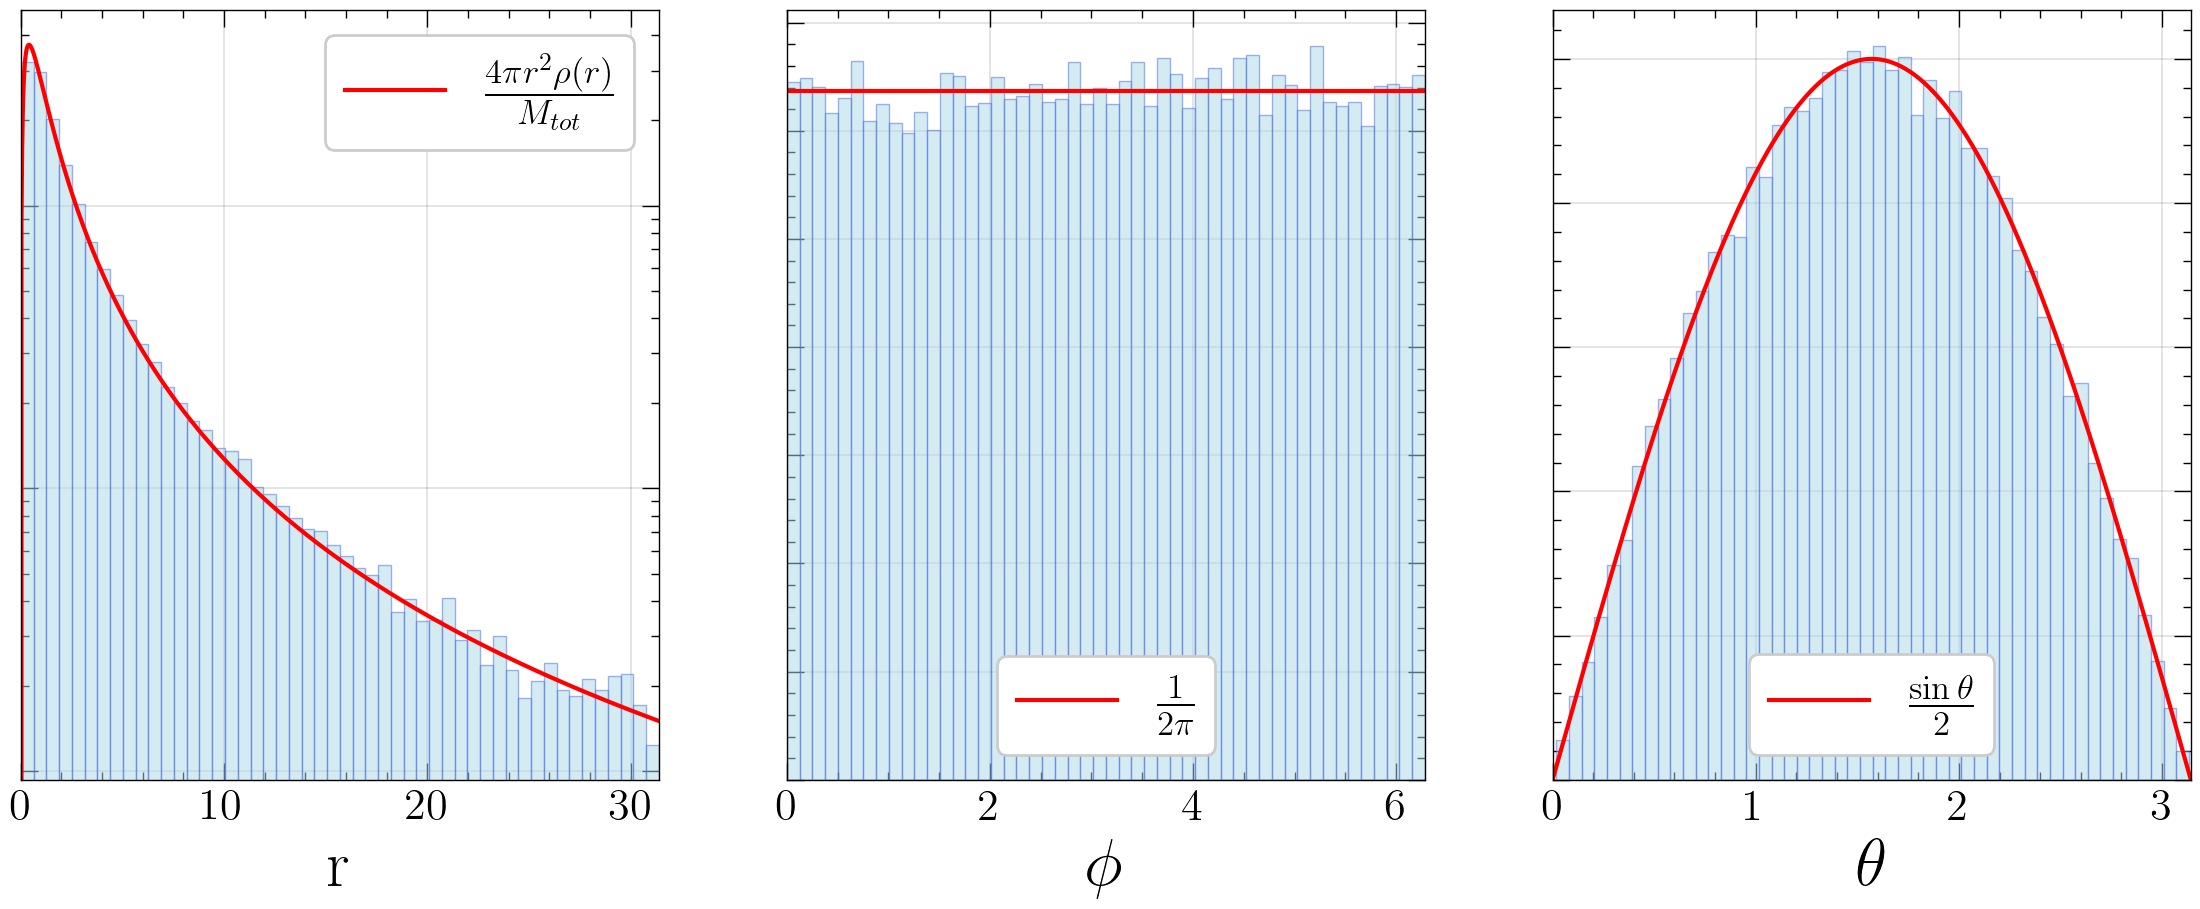

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14,5))

r_max_plot = np.quantile(r, 0.95)
ax = axes[0]
ax.hist(r[r<r_max_plot], bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, r_max_plot, 1000)
ax.plot(x_dense, (2*a*x_dense)/(x_dense + a)**3, color='red', label='$\\frac{4\pi r^2 \\rho(r)}{M_{tot}}$')
ax.set_xlim(0, r_max_plot)
ax.set_yscale('log')
ax.set_xlabel('r')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[1]
ax.hist(phi, bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, 2*np.pi, 1000)
ax.axhline(1/(2*np.pi), color='red', label='$\\frac{1}{2\pi}$')
ax.set_xlim(0, 2*np.pi)
ax.set_xlabel('$\phi$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend()

ax = axes[2]
ax.hist(theta, bins=50, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
x_dense = np.linspace(0, np.pi, 1000)
ax.plot(x_dense, 0.5*np.sin(x_dense), color='red', label='$\\frac{\sin{\\theta}}{2}$')
ax.set_xlim(0, np.pi)
ax.set_xlabel('$\\theta$')
ax.yaxis.set_tick_params(labelleft=False)
ax.legend();

## 3) Add the MBHs and set their initial positions

Since the mass of the perturber must satisfy $M \gg M_{pert} \gg m$, we choose it such that $\frac{M}{M_{pert}} = \frac{M_{pert}}{m}$

$
\begin{cases}
      M = \alpha M_{pert}\\
      M_{pert} = \alpha m\\
      M = mN
\end{cases}
\: \iff \:
\alpha = \dfrac{M}{\sqrt{N}}
$ 

In [8]:
#M_pert = M/np.sqrt(N)
M_pert = (1/100)*M
print(f'M_perturber = {M_pert:.3f}')
print(f'M / M_perturber  = {M/M_pert:.1f}')
print(f'M_perturber / m = {M_pert/m:.1f}')

M_perturber = 100.000
M / M_perturber  = 100.0
M_perturber / m = 500.0


We have to create an array for the masses

In [9]:
masses = m*np.ones(N)
masses[-1] = M_pert
masses[-2] = M_pert

We set the initial position of the perturber such that $r_{pert,0} = {\rm{quantile}}(r; 75\%)$

In [ ]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    #The following looks more elegant, but it is less memory-efficient, especially for large arrays
    #return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x[:-2], y[:-2], z[:-2], 0, 0, 0) # It is equal to the array r[:-2]

CMpos_vector = np.array([np.sum(x[:-2]), np.sum(x[:-2]), np.sum(x[:-2])])/(N-2)
CMpos = np.linalg.norm(CMpos_vector)
print(f'CM position = {CMpos:.3f}')


CM position = 0.015


In [11]:
mask = dist_particle<np.quantile(dist_particle, 0.9)
CMpos_q9_vector = np.array([np.sum(x[:-2][mask]), np.sum(y[:-2][mask]), np.sum(z[:-2][mask])])/(N-2)
CMpos_q9 = np.linalg.norm(CMpos_q9_vector)
print(f'CM position 90% = {CMpos_q9:.3f}')

dist_pert = np.quantile(dist_particle, 0.75)
print(f'r_perturber = {dist_pert:.3f}')
print(f'r_perturber - CM position 90% = {dist_pert-CMpos_q9:.3f}')

CM position 90% = 0.014
r_perturber = 5.212
r_perturber - CM position 90% = 5.198


In [12]:
x[-1] = dist_pert
y[-1] = 0
z[-1] = 0

In [13]:
x[-2] = -dist_pert
y[-2] = 0
z[-2] = 0

## 4) Velocities

Sample the angles by using the direct Monte Carlo method

In [14]:
phi = 2*np.pi*np.random.uniform(0, 1, N)
theta = np.arccos(1-2*np.random.uniform(0, 1, N))

Sample $v$ by using the acceptance-rejection method

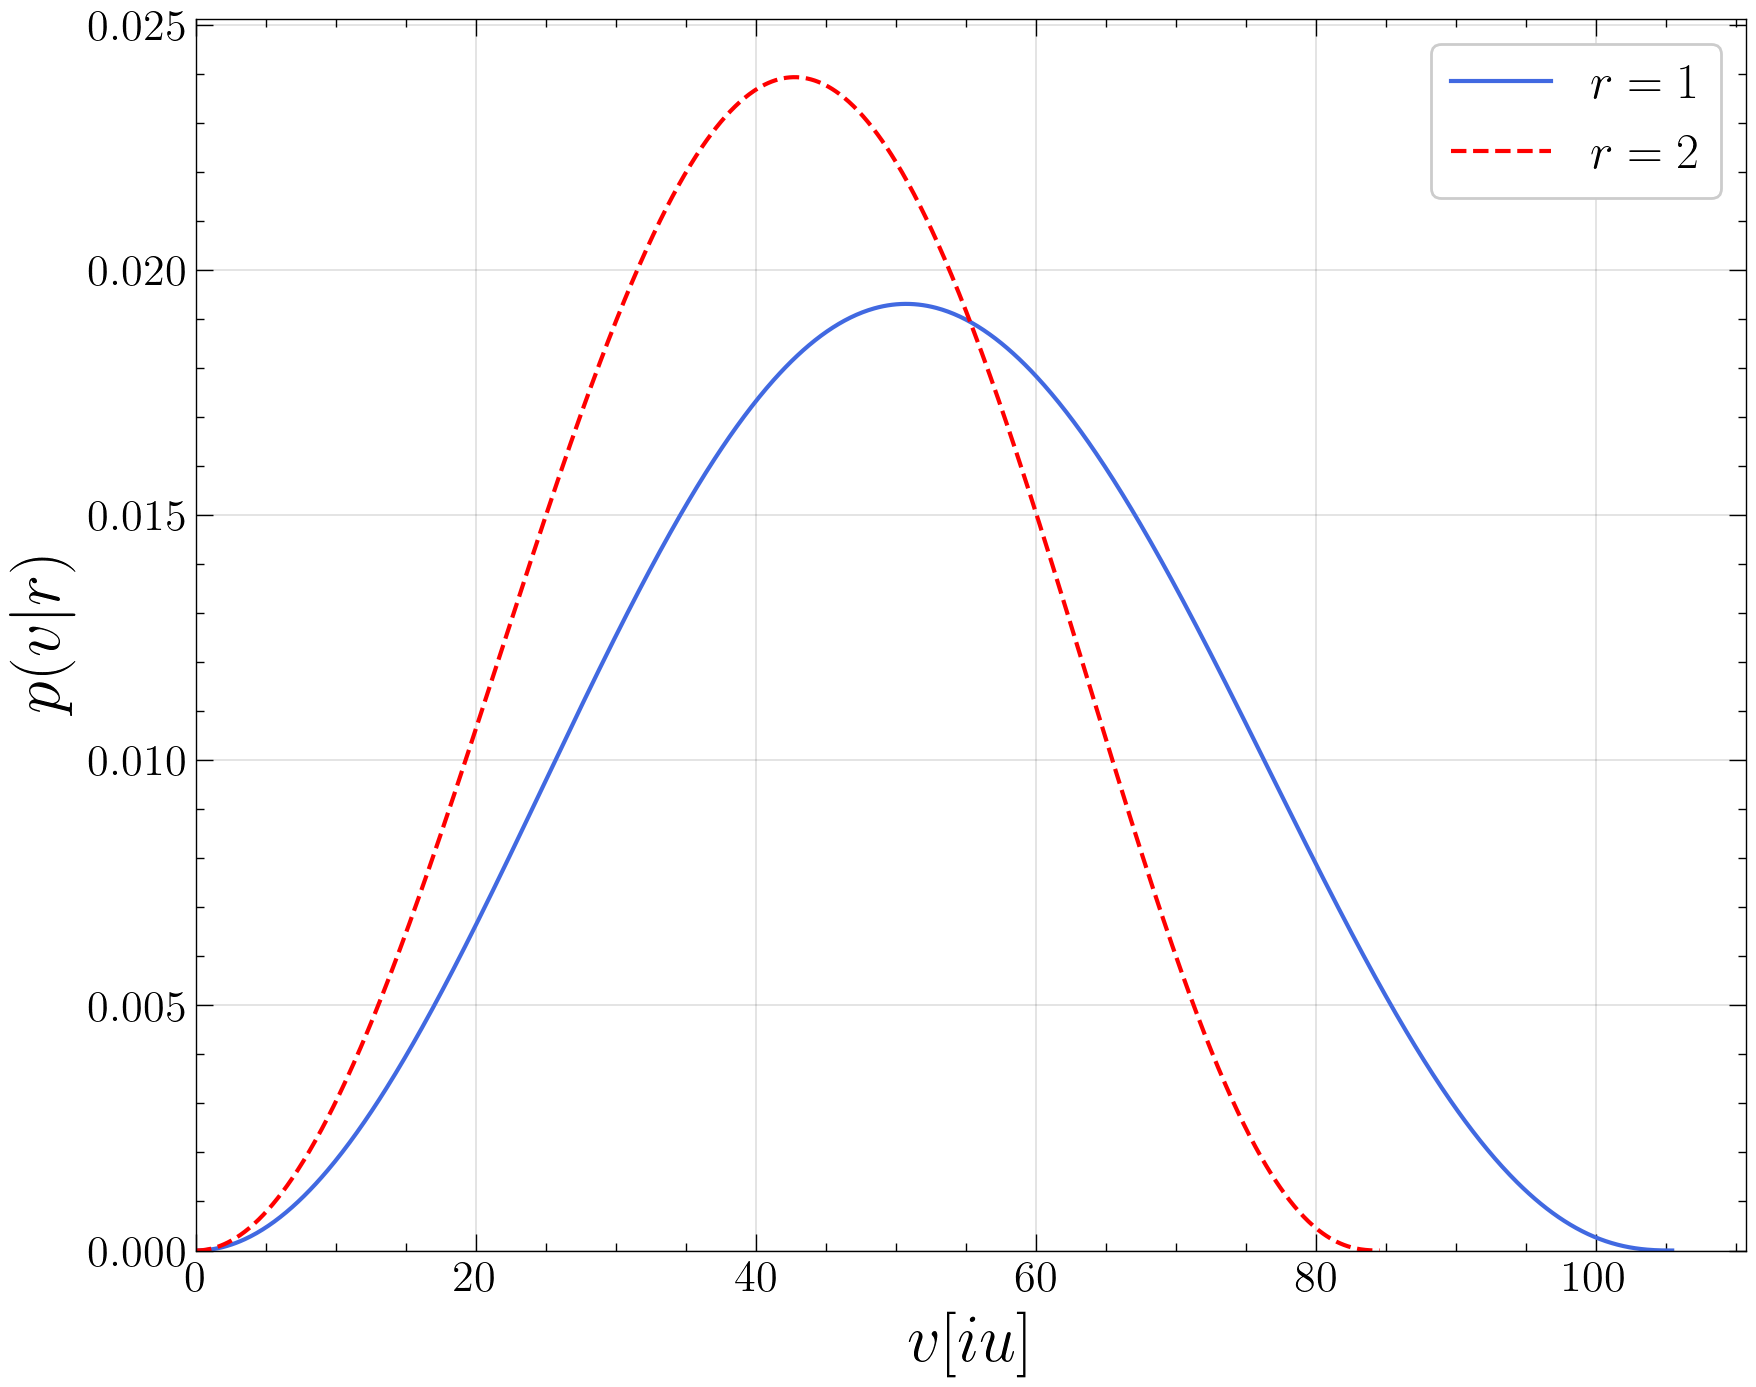

In [15]:
def phiG(r):
    return -M/(r + a)

def v_escape(r):
    return np.sqrt(-2*(phiG(r)))

def density(r):
    return M/(2*np.pi) * a/(r*(r+a)**3)

def f_of_q(q):
    result = np.zeros_like(q, dtype=float)
    mask = np.logical_and(q > 0, q < 1)
    C_norm = M/(8*np.sqrt(2)*np.pi**3*a**3*(M/a)**(3/2))
    result[mask] = C_norm * (1-q[mask]**2)**(-5/2) * (3*np.arcsin(q[mask]) + q[mask]*np.sqrt(1-q[mask]**2)*(1-2*q[mask]**2)*(8*q[mask]**4-8*q[mask]**2-3))
    result[~mask] = 0
    return result
    #return C_norm * (1-q**2)**(-5/2) * (3*np.arcsin(q) + q*np.sqrt(1-q**2)*(1-2*q**2)*(8*q**4-8*q**2-3))

def p_of_v(v, r=1):
    q = np.sqrt(np.abs((0.5*v**2 + phiG(r))/phiG(0)))
    return 4*np.pi*v**2 * f_of_q(q) / density(r)

r_trial = 1
v_dense = np.linspace(0, v_escape(r_trial), 1000)
plt.plot(v_dense, p_of_v(v_dense, r_trial), color='royalblue', label='$r=1$')

r_trial2 = 2
v_dense2 = np.linspace(0, v_escape(r_trial2), 1000)
plt.plot(v_dense2, p_of_v(v_dense2, r_trial2), color='red', ls='--', label='$r=2$')

plt.xlim(0)
plt.ylim(0)
plt.xlabel('$v[iu]$')
plt.ylabel('$p(v|r)$')
plt.legend();

In [16]:
v = np.zeros(N)

phi_array = phiG(r)
v_escape_array = v_escape(r)

for i in tqdm(range(N)):
    while v[i] == 0:
        v_dense = np.linspace(0, v_escape_array[i], 1000)
        v_trial = np.random.uniform(0, v_escape_array[i])
        p_trial = p_of_v(v_trial, r[i])
        
        p_max = np.max(p_of_v(v_dense, r[i]))
        u_trial = np.random.uniform(0, 1.1*p_max)
        
        if u_trial < p_trial:
            v[i] = v_trial

  0%|          | 0/50002 [00:00<?, ?it/s]

100%|██████████| 50002/50002 [00:11<00:00, 4417.74it/s]


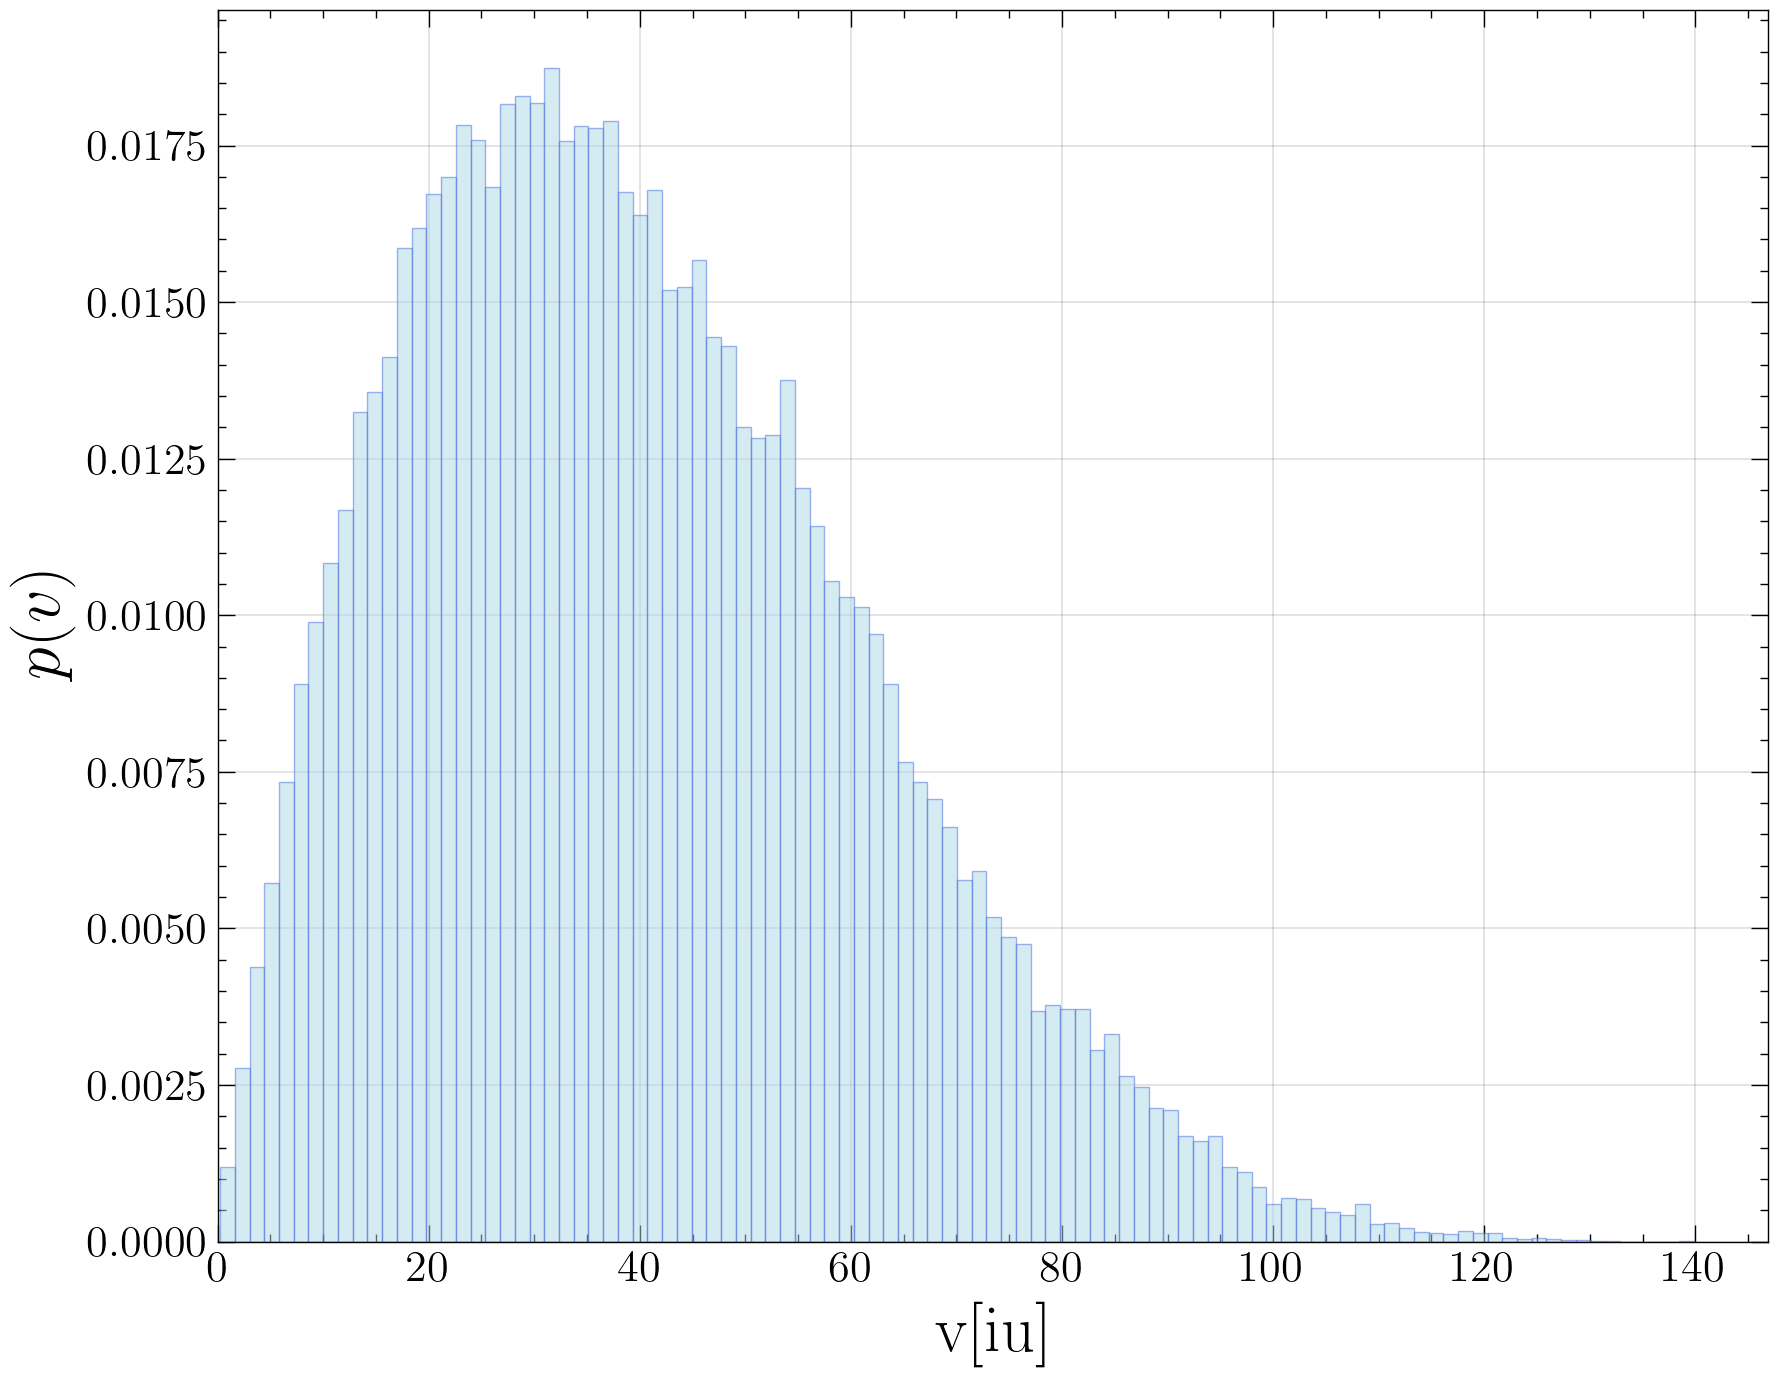

In [17]:
plt.hist(v, bins=100, density=True, color='lightblue', edgecolor='royalblue', linewidth=0.5, alpha=0.5)
plt.xlim(0)
plt.xlabel('v[iu]')
plt.ylabel('$p(v)$');

We can use the virial theorem to check the results

In [ ]:
from scipy.spatial.distance import pdist

positions = np.stack((x[:-2], y[:-2], z[:-2]), axis=1)  # Shape (N-2, 3)
dists = pdist(positions)                                # Only unique pairs
U_tot = -m**2 * np.sum(1.0 / dists)

# Incredibly faster than
#U_tot = 0
#for i in tqdm(range(N-2)):
#    for j in range(i+1, N-2):
#        r_ij = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
#        U_tot += -m**2/r_ij

K_tot = 0
for i in tqdm(range(N)):
    K_tot += 0.5*masses[i]*v[i]**2  
        
print(K_tot/U_tot)

Transform from spherical coordinates to Cartesian coordinates

In [18]:
vx = v*np.sin(theta)*np.cos(phi)
vy = v*np.sin(theta)*np.sin(phi)
vz = v*np.cos(theta)

Let us redefine the velocities of the perturbers to have a more reproducible system

In [19]:
v_circ = np.sqrt(m*np.sum(dist_particle < x[-1]) / x[-1])
v_circ

37.932789667529455

In [20]:
vx[-1] = 0
vy[-1] = v_circ
vz[-1] = 0

print(x[-1], y[-1], z[-1])
print(vx[-1], vy[-1], vz[-1])

5.212327525578558 0.0 0.0
0.0 37.932789667529455 0.0


In [21]:
vx[-2] = 0
vy[-2] = 0
vz[-2] = v_circ

print(x[-2], y[-2], z[-2])
print(vx[-2], vy[-2], vz[-2])

-5.212327525578558 0.0 0.0
0.0 0.0 37.932789667529455


In [22]:
r_influence = M_pert/np.var(v)
print(f'r_influence = {1e3*r_influence:.1f} pc')

r_influence = 212.4 pc


## 5) Create the input file

In [23]:
# open the file
file = open('project.in', 'w')

# write the file
file.write(f'{N}\n')
file.write('3\n')
file.write('0\n')

for i in range(N):
    file.write(f'{masses[i]}\n')

for i in range(N):
    file.write(f'{x[i]} {y[i]} {z[i]}\n')
    
for i in range(N):
    file.write(f'{vx[i]} {vy[i]} {vz[i]}\n')

# close the file
file.close()

## 6) Numerical estimation of some parameters

### 6.1) Softening parameter

In [24]:
r_median = np.quantile(r, 0.5)
r_median

1.948030101343959

In [25]:
V_at_r_median = (4/3)*np.pi*r_median**3
softening = (V_at_r_median/(N/2))**(1/3)
print(softening)

0.10739220012846944


### 6.2) Dynamical timescale

In [26]:
rho = density(r)
rho_mean = np.mean(rho)
print(f'rho_mean = {rho_mean:.3f}')

rho_mean = 1261.612


In [27]:
t_dyn = np.sqrt(3*np.pi/(16*rho_mean))
print(f't_dyn = {t_dyn:.4f}')

t_dyn = 0.0216
